In [26]:
%load_ext autoreload
%autoreload 2
import pickle

import pandas as pd

import data_pre_processing
import dataset_pre_processing
import pre_training
import raw_data_processing
from raw_data_processing import process_PAMAP2_all_data, process_hhar_all_files, process_motion_sense_all_files, open_pickle
import numpy as np
import scipy.stats
import data_pre_processing
import self_har_models
import tensorflow as tf
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
with open('pickled_datasets/pamap.pickle', 'rb') as file:
    pamap_df = pickle.load(file)
with open('pickled_datasets/hhar.pickle', 'rb') as file:
    hhar_df = pickle.load(file)
with open('pickled_datasets/motionsense.pickle', 'rb') as file:
    motion_sense_df = pickle.load(file)
    
def concat_datasets(datasets, sensor_type):
    concated_datasets = {}
    ##TODO need to check key to see whether mag exists
    for df in datasets:
        concated_datasets.update(df[sensor_type])
    return concated_datasets

cdf = concat_datasets([pamap_df, hhar_df, motion_sense_df], "acc")
def get_labels(data):
    all_labels = []
    for user in data:
        all_labels = np.concatenate((np.unique(data[user][0][1]), all_labels))
    labels = np.unique(all_labels)
    return labels

labels = get_labels(cdf)
label_map = {label: index for index, label in enumerate(labels)}
print(label_map)
user_datasets_processed = data_pre_processing.pre_process_dataset_composite(
    cdf, label_map, 6, 
    ['101', '102', '103', '104', '105', '106', '107', 'a', 'b', 'c', 'd', 'e', 'f', 'g', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'], 
    ["108", "109", "h", "i", "21", "22", "23", "24"], 400, 200, verbose=1
)

{'IMU ankle': 0, 'IMU chest': 1, 'IMU hand': 2, 'Phone': 3, 'Watch': 4, 'iphone': 5}
here
splitting training
normalising
getting mean
0
[-0.18597652  1.40292431  4.05411898]
[6.31367612 5.0870368  5.47022979]
normalising train set
normalisnig test
mapping
Test
(array(['IMU ankle', 'IMU chest', 'IMU hand', 'Phone', 'Watch', 'iphone'],
      dtype='<U9'), array([ 2070,  2076,  2071, 12825,   995,  1080]))
(array([0, 1, 2, 3, 4, 5]), array([ 2070,  2076,  2071, 12825,   995,  1080]))
-----------------
Train
(array(['IMU ankle', 'IMU chest', 'IMU hand', 'Phone', 'Watch', 'iphone'],
      dtype='<U9'), array([12224, 12270, 12221, 43567, 14100,  5550]))
(array([0, 1, 2, 3, 4, 5]), array([12224, 12270, 12221, 43567, 14100,  5550]))
-----------------
Training data shape: (79945, 400, 3)
Validation data shape: (19987, 400, 3)
Testing data shape: (21117, 400, 3)


In [28]:
test_model = self_har_models.create_1d_conv_core_model((400,3), "HAR")
cnn_model = self_har_models.attach_full_har_classification_head(test_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
cnn_history = cnn_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

Epoch 1/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.2020 - categorical_accuracy: 0.9428 - auc: 0.9944 - precision: 0.9488 - recall: 0.9373 - val_loss: 0.1764 - val_categorical_accuracy: 0.9540 - val_auc: 0.9971 - val_precision: 0.9638 - val_recall: 0.9327
Epoch 2/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1400 - categorical_accuracy: 0.9590 - auc: 0.9970 - precision: 0.9617 - recall: 0.9570 - val_loss: 0.1863 - val_categorical_accuracy: 0.9492 - val_auc: 0.9959 - val_precision: 0.9553 - val_recall: 0.9442
Epoch 3/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1251 - categorical_accuracy: 0.9641 - auc: 0.9975 - precision: 0.9663 - recall: 0.9619 - val_loss: 0.1409 - val_categorical_accuracy: 0.9602 - val_auc: 0.9977 - val_precision: 0.9642 - val_recall: 0.9569
Epoch 4/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1153 - categorical_accuracy: 0.9673 - auc: 0.9979 - precision: 0.9688 - 

660/660 [==============================] - 6s 9ms/step - loss: 0.6838 - categorical_accuracy: 0.8680 - auc: 0.9484 - precision: 0.8705 - recall: 0.8644


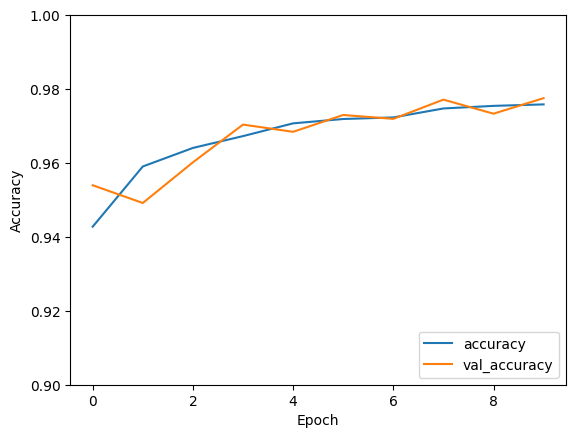

In [29]:
import matplotlib.pyplot as plt
plt.plot(cnn_history.history['categorical_accuracy'], label='accuracy')
plt.plot(cnn_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')

test_result = full_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)

In [ ]:
self_har_models.save_model_results(full_model, user_datasets_processed[2][0],  user_datasets_processed[2][1], "test_results.txt")

In [ ]:
predicted_labels = np.argmax(full_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)



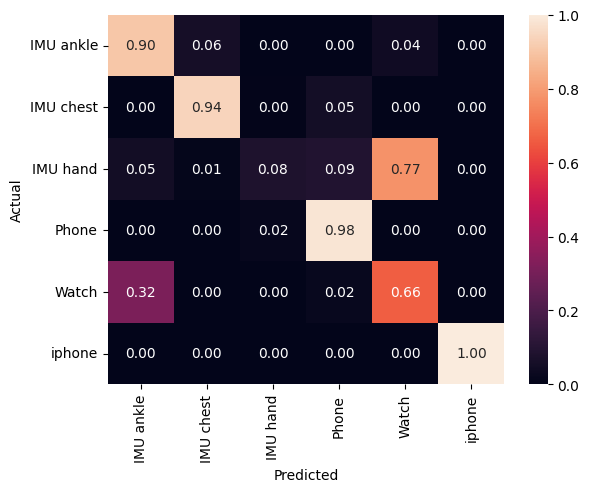

In [56]:
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

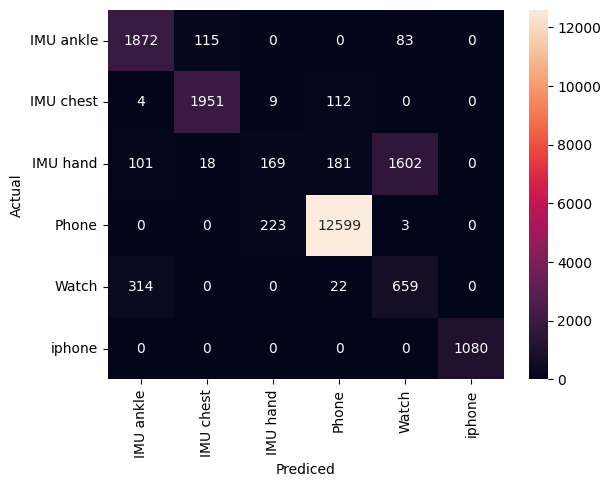

In [50]:
sns.heatmap(confusion_mat, annot=True, xticklabels=labels, yticklabels=labels, fmt='1')
plt.ylabel('Actual')
plt.xlabel('Prediced')
plt.show(block=False)

In [ ]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Conv1D(
        32, 24,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv1D(
        64, 16,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv1D(
    96, 8,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96))(x)
x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='sigmoid')(x)

this_model = tf.keras.Model(inputs, x, name="LSTM")


In [ ]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Conv1D(
        32, 24,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv1D(
        64, 16,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv1D(
    96, 8,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96))(x)
x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='sigmoid')(x)
LSTM_CNN_model = tf.keras.Model(inputs, x, name="LSTM-CNN")
print(LSTM_CNN_model.summary())

In [ ]:
full_model = self_har_models.attach_full_har_classification_head(LSTM_CNN_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
history = full_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

In [ ]:
tf.saved_model.save(full_model, "saved_models")